In [1]:
import sys,os
os.chdir('../../')
sys.path.append('./src/data')
sys.path.append('./src/events')
sys.path.append('./src/probability')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from DC.importer import *
from DC.processer import *
from DC.main import get_all_events,get_events
from functions import perform_chisq, dc_params_nsi, dc_params
from DC.event_processing import list_of_params_nsi, return_precomputed_nsi, get_deltachi
from scipy.stats import chi2
import pickle
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 100
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')
np.set_printoptions(linewidth=200)

In [2]:
ndim = 3
pid = 1
precomputed_events = False
dc_params_nsi['dm_41'] = 0.93
dc_params['dm_41'] = 0.93
emm_range = np.linspace(0,0,1)
s24_range = np.linspace(0,0,1)
emt_range = np.linspace(-1e-2,1e-2,10)
param_list = list_of_params_nsi(dc_params_nsi,s24_range, emm_range,emt_range)

#for p in param_list: # Assert all dicts returned from param_list have precomputed probs.
#    assert is_precomputed_nsi(N=N,ndim=ndim, dict=p,check=False)



param_list = return_precomputed_nsi(pid,ndim,params=param_list)
emm_range = np.sort(np.unique(np.array([p['e_mm'] for p in param_list])))
s24_range = np.sin(2*np.sort(np.unique(np.array([p['theta_24'] for p in param_list]))))**2
emt_range = np.sort(np.unique(np.array([p['e_mt'] for p in param_list])))

print(emm_range)
print(s24_range)
print(emt_range)

#print(param_list[1])

[0.]
[0.]
[-0.01       -0.00777778 -0.00555556 -0.00333333 -0.00111111  0.00111111  0.00333333  0.00555556  0.00777778  0.01      ]


In [3]:
param_list = [param_list[0]]

In [4]:
if not precomputed_events:
    print('Computing events')
    from multiprocessing import Pool
    p = Pool()
    data = [(p, pid,True) for p in param_list]
    H1_events_list = p.starmap(get_all_events, data)
    p.close()
    pickle.dump(H1_events_list,open(f'./pre_computed/H1_DC_{pid}_{len(emm_range)}x{len(emt_range)}_tau_nsi.p','wb'))

    H0_events = get_all_events(params=param_list[0], pid=pid, nsi=False)
    pickle.dump(H0_events,open(f'./pre_computed/H0_DC_{pid}.p','wb'))

H1_events_list = pickle.load(open(f'./pre_computed/H1_DC_{pid}_{len(emm_range)}x{len(emt_range)}_tau_nsi.p','rb'))
H0_events = pickle.load(open(f'./pre_computed/H0_DC_{pid}.p','rb'))

no_osc = get_all_events(params=param_list[0], pid=pid, nsi=False, no_osc=True)
track_factors = normalization_factors(np.sum(no_osc,axis=1), np.sum(no_osc,axis=1))[0]
normalized_tracks = [track_factors*np.sum(H1,axis=1) for H1 in H1_events_list]

Computing events


In [5]:
events = get_hist(events2018_DC().query('pid==1'), 'count_events')
background = get_hist(events2018_DC().query('pid==1'), 'count_background')
events_E = np.sum(events,axis=1)
background_E = np.sum(background,axis=1)

In [6]:
best_fit_contamination = 0.055/(np.sum(background_E)/np.sum(events_E)) #table 1 DC2017

In [7]:
track_events = np.array([1273.0929915101788,
1324.139298304307,
1728.8833542945758,
2056.4569922784135,
2522.294295857107,
2480.0909490796657,
2132.423429507234,
1604.6895361059978])

In [10]:
MC2018 = MC2018_DC()
MC2018 = multiply_fluxes(MC2018)
systematics2018 = systematics2018_DC()
no_osc_tracks = process_systematics(MC2018, systematics2018, pid)

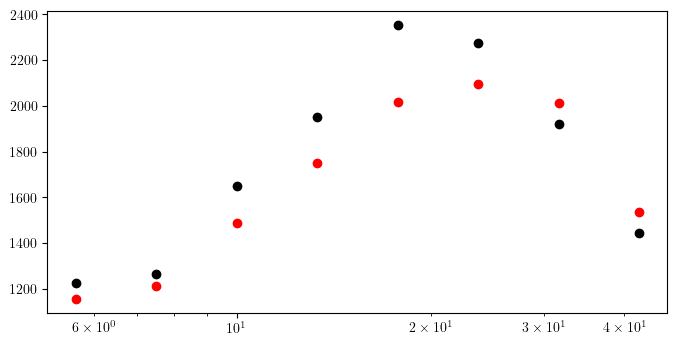

In [20]:
#plt.fill_between(Ebins_2018[0:-1], np.sum(922*24*3600*H1_events_list[0],axis=1), np.sum(922*24*3600*H1_events_list[9],axis=1))
plt.scatter(Ebins_2018[0:-1], events_E-best_fit_contamination*background_E, color='black')
#plt.scatter(Ebins_2018[0:-1], track_events, color='green') 
plt.scatter(Ebins_2018[0:-1], track_factors*np.sum(H0_events,axis=1), color='red') 
plt.xscale('log')

In [13]:
track_factors, cascade_factors = normalization_factors(H0_events, H0_events)

In [14]:
normalized_tracks = [np.sum(MC_tracks,axis=1)*track_factors for MC_tracks in H1_events_list]

In [25]:
sigma_a = 0.25
sigma_b = 0.04
f = 0
deltachi, best_index, H1_chisq = get_deltachi(normalized_tracks,pid,emt_range,emm_range,0,[sigma_a,sigma_b],f,x0=[1])
#s24_cl90, s24_cl99, emm_cl90, emm_cl99 = get_contour(deltachi.T, emt_range,emm_range,2)
#best_fit_coords = (param_list[best_index]['e_mt'], param_list[best_index]['e_mm'])

In [36]:
normalized_tracks

[array([2042.98826833, 2539.29351879, 3449.07164966, 4099.4475172 , 3414.84682208, 1976.63761286,  968.33637713,  596.85452325]),
 array([2034.92950983, 2534.16211075, 3445.99627102, 4097.86227128, 3413.56632074, 1974.76924899,  966.71233216,  595.42316741]),
 array([2027.94300649, 2529.20772839, 3442.99362056, 4096.23069292, 3412.29281384, 1972.91853813,  965.20072061,  594.22604572]),
 array([2021.98460491, 2524.39824874, 3439.95852606, 4094.6463962 , 3411.04388735, 1971.12309772,  963.82397506,  593.32799435]),
 array([2016.92876449, 2519.83731292, 3436.99199161, 4093.10770014, 3409.80986121, 1969.38558114,  962.57987648,  592.65553294]),
 array([2013.00438186, 2515.51225122, 3434.07085971, 4091.60692345, 3408.59631333, 1967.66726187,  961.46336321,  592.30211764]),
 array([2010.23434087, 2511.4099665 , 3431.14204719, 4090.13761251, 3407.38972662, 1965.98380204,  960.45785067,  592.28906859]),
 array([2008.37046991, 2507.55813079, 3428.33873104, 4088.72407993, 3406.2103694 , 1964.36

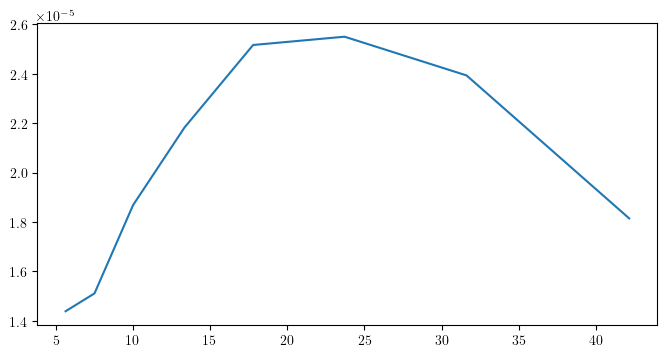

In [47]:
plt.plot(Ebins_2018[0:-1], np.sum(H0_events,axis=0))

In [56]:
np.array([Ebin*zbin for zbin in range(4) for Ebin in range(8)]).reshape(4,8)

array([[ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  2,  3,  4,  5,  6,  7],
       [ 0,  2,  4,  6,  8, 10, 12, 14],
       [ 0,  3,  6,  9, 12, 15, 18, 21]])

In [59]:
np.sum(np.array([Ebin*zbin for Ebin in range(8) for zbin in range(4)]).reshape(8,4),axis=1)

array([ 0,  6, 12, 18, 24, 30, 36, 42])

In [42]:
[np.sum(np.sum(MC_tracks,axis=1)*track_factors) for MC_tracks in H1_events_list]

[19087.476289302784,
 19063.421232162247,
 19041.013166657227,
 19020.30673039287,
 19001.29662094442,
 18984.2234722958,
 18969.04441500369,
 18955.615662846267,
 18943.741346604183,
 18933.927943118375]

In [26]:
deltachi

array([[94.20967247],
       [83.11126207],
       [72.22921873],
       [61.45990986],
       [50.88571644],
       [40.39422012],
       [30.01610826],
       [19.84414171],
       [ 9.87801602],
       [ 0.        ]])

In [9]:
events2018_DC().query(f'pid=={pid}')['count_events']

array([[196., 210., 242., 224., 177.,  97.,  67.,  43.],
       [176., 171., 247., 206., 197., 136., 103.,  66.],
       [216., 194., 253., 281., 269., 204., 167., 118.],
       [177., 208., 262., 336., 374., 299., 202., 175.],
       [182., 212., 326., 464., 421., 392., 265., 216.],
       [133., 217., 342., 496., 454., 360., 267., 177.],
       [121., 224., 295., 389., 427., 315., 224., 109.],
       [129., 192., 242., 313., 281., 226., 139.,  58.]])

In [21]:
events2018_DC().query(f'pid=={pid}').pivot(columns='reco_coszen', index='reco_energy')['count_events']

reco_coszen,-0.875,-0.625,-0.375,-0.125,0.125,0.375,0.625,0.875
reco_energy,,,,,,,,
6.6,196.0,210.0,242.0,224.0,177.0,97.0,67.0,43.0
8.7,176.0,171.0,247.0,206.0,197.0,136.0,103.0,66.0
11.7,216.0,194.0,253.0,281.0,269.0,204.0,167.0,118.0
15.6,177.0,208.0,262.0,336.0,374.0,299.0,202.0,175.0
20.7,182.0,212.0,326.0,464.0,421.0,392.0,265.0,216.0
27.7,133.0,217.0,342.0,496.0,454.0,360.0,267.0,177.0
36.9,121.0,224.0,295.0,389.0,427.0,315.0,224.0,109.0
49.2,129.0,192.0,242.0,313.0,281.0,226.0,139.0,58.0
